In [1]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# -- import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

# -- Print torch and cuda versions
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


# -- Generic libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from IPython.display import Image

torch:  1.10 ; cuda:  1.10.2


In [2]:
# -- Variables
data_folder = 'data/img/'
thing_classes=['Person']

In [3]:
def get_thing_dicts(json_path):
    with open(json_path) as f:
        dataset_dicts = json.load(f)
    return dataset_dicts
get_thing_dicts(
    os.path.join(data_folder, 'train', 'train.json')
)

[{'file_name': 'data/img/train/a00000.png',
  'image_id': 0,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [209, 214, 20, 24],
    'bbox_mode': 1,
    'category_id': 0}]},
 {'file_name': 'data/img/train/a00010.png',
  'image_id': 1,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [209, 214, 20, 24],
    'bbox_mode': 1,
    'category_id': 0}]},
 {'file_name': 'data/img/train/a00020.png',
  'image_id': 2,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [209, 214, 20, 24],
    'bbox_mode': 1,
    'category_id': 0}]},
 {'file_name': 'data/img/train/a00030.png',
  'image_id': 3,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [211, 215, 18, 24],
    'bbox_mode': 1,
    'category_id': 0}]},
 {'file_name': 'data/img/train/a00040.png',
  'image_id': 4,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [95, 214, 41, 23],
    'bbox_mode': 1,
    'category_id': 0},
   {'bbox': [211, 215, 17, 23], 'bbox_mode': 1, 'category_id': 0}]},
 {'f

In [4]:
# -- Register dataset
for d in ["train", "valid"]:
    DatasetCatalog.register(
        "thing_"+d, 
        lambda d=d: get_thing_dicts(
            os.path.join(data_folder, d, f'{d}.json')
        )
    )
    MetadataCatalog.get("thing_"+d).set(
        thing_classes=thing_classes
    )
thing_metadata = MetadataCatalog.get("thing_train")
thing_metadata

namespace(name='thing_train', thing_classes=['Person'])

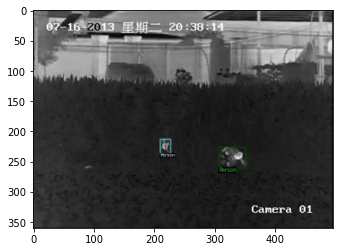

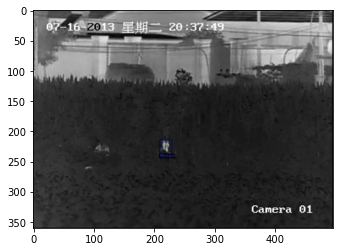

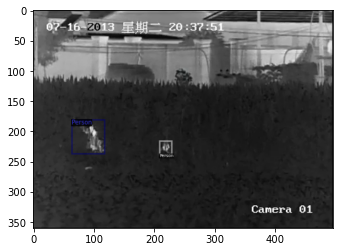

In [5]:
dataset_dicts = get_thing_dicts(data_folder+"train/"+'train.json')
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(
        img[:, :, ::-1], 
        metadata=thing_metadata, 
        scale=1
    )
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [6]:
# zooed_model = \
#     'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
zooed_model = \
    'COCO-Detection/retinanet_R_50_FPN_1x.yaml'

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(zooed_model))
cfg.INPUT.MIN_SIZE_TRAIN = (400,)
cfg.DATASETS.TRAIN = ("thing_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(zooed_model)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64#128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.MODEL.RETINANET.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrectly use num_classes+1 here.

Loading config c:\users\admin\desktop\canadian application\jobs\detectron2\detectron2\detectron2\model_zoo\configs\COCO-Detection\../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


## Inference & evaluation using the trained model

Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

In [7]:
import os
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(
    cfg.OUTPUT_DIR, "model_final.pth"
)  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5   # set a custom testing threshold
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = .5
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [8]:
'''
dataset_dicts = get_thing_dicts(
    os.path.join(data_folder, 'test', 'test.json')
)
for d in random.sample(dataset_dicts, 13):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=thing_metadata, 
                   scale=0.5, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
'''

'\ndataset_dicts = get_thing_dicts(\n    os.path.join(data_folder, \'test\', \'test.json\')\n)\nfor d in random.sample(dataset_dicts, 13):    \n    im = cv2.imread(d["file_name"])\n    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format\n    v = Visualizer(im[:, :, ::-1],\n                   metadata=thing_metadata, \n                   scale=0.5, \n#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models\n                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models\n    )\n    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))\n    plt.imshow(out.get_image()[:, :, ::-1])\n    plt.show()\n'

In [10]:
def render_predicted_image(image, writer=None, show=False):
    outputs = predictor(image)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(image[:, :, ::-1],
                   metadata=thing_metadata, 
#                    scale=0.5, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
#                    instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    frame = out.get_image()[:,:,::-1]
    if show:
        cv2.imshow('Result', frame)
    if writer is not None:
        writer.write(frame)
def onVideo(
    video_path, output_path, 
    render_predicted_image,
    write=True, show=False
):
    video_stream = cv2.VideoCapture(video_path)
    
    height = int(video_stream.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(video_stream.get(cv2.CAP_PROP_FRAME_WIDTH))
    # video_size = (360, 496)
    
    if write:
        writer = cv2.VideoWriter(
            output_path,
            cv2.VideoWriter_fourcc(*"MP4V"), 
            30, 
            (width, height)
        )

    
    if (video_stream.isOpened() == False):
        print('Error opening the file...')
        return 
    (success, image) = video_stream.read()
    while success:
        render_predicted_image(image, writer=writer, show=False)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        (success, image) = video_stream.read()
    # Release video object
    video_stream.release()
    if write:
        writer.release()
onVideo(
    'data/2.mp4', 'submission/output2.mp4', 
    render_predicted_image,
    write=True, show=False
)